In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
import math
pd.options.display.max_rows=200
import seaborn as sns

In [2]:
df_id_result = pd.read_csv('/data/210827_SJH_prosit/search_result/massIVE-KB_result.tsv', sep='\t')
df_nid_result = pd.read_csv('/data/210827_SJH_prosit/search_result/uniprot_result.tsv', sep='\t')

In [3]:
print(df_id_result.shape)
df_id_result.head(1)

(1515056, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,massIVE-KB_predMS2_frac01.mgf,index=22130,-1,"22131 File:""massIVE-KB_predMS2.RAW"", NativeID:...",HCD,915.407,0,0.066675,4,NQSQGYNQWQQGQFWGQKPWSQHYHQGYY,"sp|Q00839|HNRPU_HUMAN(pre=K,post=-);tr|A0A1X7S...",264,264,2.147724e-42,5.912638e-35,0.0,0.0


In [4]:
print(df_nid_result.shape)
df_nid_result.head(1)

(1287214, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,uniprot_predMS2_frac01.mgf,index=91704,-1,"91705 File:""uniprot_predMS2.RAW"", NativeID:""co...",HCD,1791.814,0,0.0,2,NTFWDVDGSMVPPEWHRWLHSMTDDPPTTK,"sp|Q9UI09|NDUAC_HUMAN(pre=K,post=P)",340,340,3.764748e-42,1.041666e-34,0.0,0.0


* remove PTM peptides

In [5]:
drop_idx = [idx for idx, p in zip(df_id_result.index, df_id_result.Peptide.values) if '+' in p]
print(len(drop_idx))
df_id_result = df_id_result.drop(drop_idx, axis=0).reset_index(drop=True)

239642


In [6]:
drop_idx = [idx for idx, p in zip(df_nid_result.index, df_nid_result.Peptide.values) if '+' in p]
print(len(drop_idx))
df_nid_result = df_nid_result.drop(drop_idx, axis=0).reset_index(drop=True)

178960


* FDR control

In [7]:
def isDecoy(prot):
    prot_cnt = len(prot.split(';'))
    decoy_cnt = 0
    for p in prot.split(';'):
        if 'XXX' in p:
            decoy_cnt += 1
    if decoy_cnt == prot_cnt:
        return 'D'
    else:
        return 'T'

In [8]:
def getFDR(TD_list):
    start = time.time()
    
    FDR_list = []
    T_cnt = 0
    D_cnt = 0
    cut_idx = 0
    
    for idx, label in enumerate(TD_list):
        if label=='T':
            T_cnt += 1
        elif label == 'D':
            D_cnt += 1
        fdr = round((2*D_cnt) / (T_cnt + D_cnt), 2)
        if fdr <= 0.01:
            cut_idx = idx
    return cut_idx

In [9]:
def FDR_control(df, PERCENT):
    df_ = df.sort_values('SpecEValue').reset_index(drop=True)  # copy
    df_['TD_label'] = df_.Protein.apply(isDecoy).values
    print('********** Target Decoy Labelling Done **********')
    cut_idx = getFDR(df_.TD_label.values)  
    print('********** Calculating FDR Done **********')
    df_ = df_.iloc[:cut_idx+1].reset_index(drop=True)
    df_ = df_.loc[df_.TD_label=='T'].reset_index(drop=True)
    return df_

In [10]:
df_id_target = FDR_control(df_id_result, 0.01)

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********


In [11]:
df_nid_target = FDR_control(df_nid_result, 0.01)

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********


In [12]:
max(df_id_target.EValue.values), min(df_id_target.EValue.values)  # maaIVE-KB

(0.21289732, 5.912637919438798e-35)

In [13]:
max(df_nid_target.EValue.values), min(df_nid_target.EValue.values)  # uniprot

(0.5287867, 4.1343436498436185e-37)

* decoy protien identificatin count

In [14]:
from matplotlib_venn import venn2, venn2_circles

nonDetection Peptide set : 2345
intersection cnt : 40
Detection Peptide set : 253
whole cnt : 2558



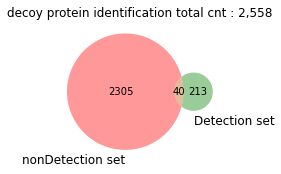

In [15]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('decoy protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

In [16]:
df_id_target_removeDecoy = df_id_target.copy()
df_nid_target_removeDecoy = df_nid_target.copy()

p = []
for prot in df_id_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_id_target_removeDecoy['Protein'] = p
df_id_target_removeDecoy = df_id_target_removeDecoy.loc[df_id_target_removeDecoy.Protein!='']
p = []
for prot in df_nid_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_nid_target_removeDecoy['Protein'] = p
df_nid_target_removeDecoy = df_nid_target_removeDecoy.loc[df_nid_target_removeDecoy.Protein!='']

In [17]:
unique_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_id_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_id_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_id_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_id_target_removeDecoy))
print("펩타이드 수 :", len(df_id_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

unique_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_nid_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_nid_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_nid_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_nid_target_removeDecoy))
print("펩타이드 수 :", len(df_nid_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

총 PSM 수 : 792514
펩타이드 수 : 504500
Unique 펩타이드 수 : 225134
Shared 펩타이드 수 : 279366
단백질 수 : 64906
총 PSM 수 : 905470
펩타이드 수 : 900455
Unique 펩타이드 수 : 424132
Shared 펩타이드 수 : 476323
단백질 수 : 64864


* Protein identification count

In [18]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' not in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' not in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

nonDetection Peptide set : 64864
intersection cnt : 61609
Detection Peptide set : 64906
whole cnt : 68161



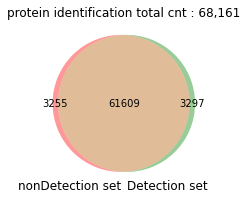

In [19]:
plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

* Peptide idenfication count

In [20]:
id_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_precursors),
         len(nid_precursors.intersection(id_precursors)),
         len(id_precursors),
         len(nid_precursors.union(id_precursors))))

nonDetection Peptide set : 900,455
intersection cnt : 2,138
Detection Peptide set : 790,757
whole cnt : 1,689,074



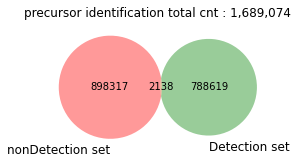

In [21]:
plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_precursors, id_precursors], set_labels=('nonDetection set', 'Detection set'))
plt.title('precursor identification total cnt : {:,}'.format(len(nid_precursors.union(id_precursors))))
plt.show()

nonDetection Peptide set : 900,455
intersection cnt : 3,658
Detection Peptide set : 504,500
whole cnt : 1,401,297



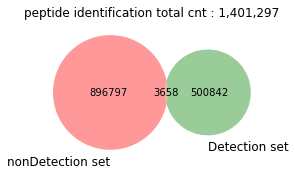

In [22]:
id_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_peptides),
         len(nid_peptides.intersection(id_peptides)),
         len(id_peptides),
         len(nid_peptides.union(id_peptides))))

plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_peptides, id_peptides], set_labels=('nonDetection set', 'Detection set'))
plt.title('peptide identification total cnt : {:,}'.format(len(nid_peptides.union(id_peptides))))
plt.show()

* MSGFscore violin plot

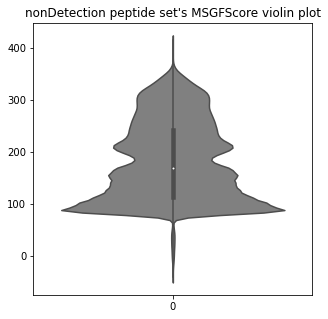

In [23]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_nid_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('nonDetection peptide set\'s MSGFScore violin plot')
plt.show()

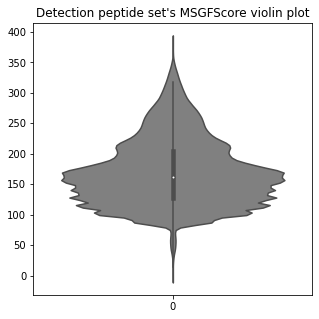

In [24]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_id_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('Detection peptide set\'s MSGFScore violin plot')
plt.show()

In [25]:
df_nonid = pd.DataFrame([[_, 'nonID', 'score'] for _ in df_nid_target_removeDecoy.MSGFScore.values],
                        columns=['MSGFScore', 'label', 'score'])
df_id = pd.DataFrame([[_, 'ID', 'score'] for _ in df_id_target_removeDecoy.MSGFScore.values],
                     columns=['MSGFScore', 'label', 'score'])

df_MSGFScore = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

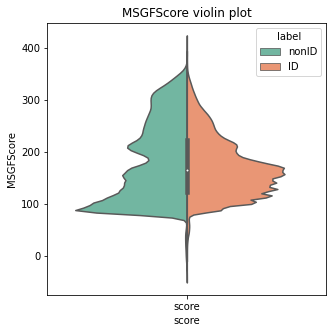

In [26]:
plt.figure(figsize=(5,5))
sns.violinplot(x='score', y="MSGFScore", hue="label",
                    data=df_MSGFScore, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('MSGFScore violin plot')
plt.show()

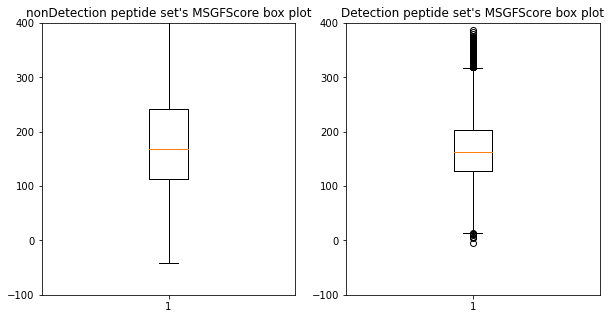

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
ax[0].boxplot(df_nid_target_removeDecoy.MSGFScore.values)
ax[1].boxplot(df_id_target_removeDecoy.MSGFScore.values)

ax[0].set_ylim(-100, 400)
ax[1].set_ylim(-100, 400)
ax[0].set_title('nonDetection peptide set\'s MSGFScore box plot')
ax[1].set_title('Detection peptide set\'s MSGFScore box plot')

plt.show()

# 3d plotting

In [54]:
df_id_2d = pd.DataFrame([[len(p), m, 'ID', 'score'] for p, m in df_id_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])
df_nonid_2d = pd.DataFrame([[len(p), m, 'nonID', 'score'] for p, m in df_nid_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])

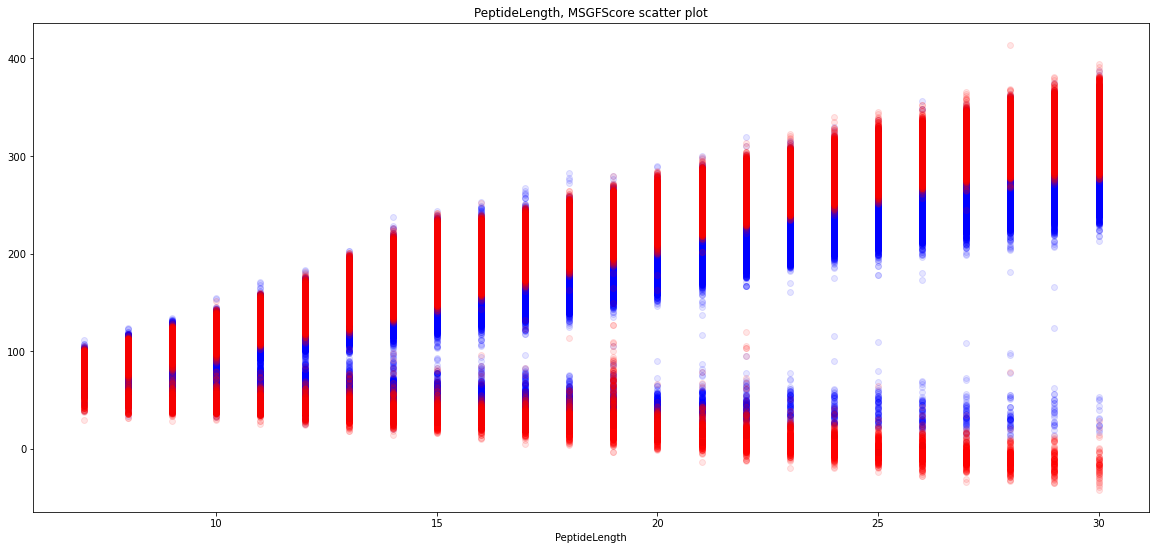

In [48]:
plt.figure(figsize=(20,9))

p = df_id_2d.sort_values('PeptideLength').PeptideLength.values
m = df_id_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='blue', label='ID')
p = df_nonid_2d.sort_values('PeptideLength').PeptideLength.values
m = df_nonid_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='red', label='nonID')

plt.title('PeptideLength, MSGFScore scatter plot')
plt.xlabel('PeptideLength')
plt.show()

In [67]:
df_nonid_2d.tail(2)

,PeptideLength,MSGFScore,Label,score
905482,14,37,nonID,score
905483,12,28,nonID,score


In [58]:
print('id min max : ', min(df_id_2d.MSGFScore.values), max(df_id_2d.MSGFScore.values), 
      '\nnid min max : ', min(df_nonid_2d.MSGFScore.values), max(df_nonid_2d.MSGFScore.values))

id min max :  -4 387 
nid min max :  -42 414


In [64]:
lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-42, 415)}
for p, m in df_id_2d[['PeptideLength', 'MSGFScore']].values:
    lenscore2freq[(p, m)] += 1
df_id_3d = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [66]:
lenscore2freq = {(p, m):0 for p in range(7, 31) for m in range(-42, 415)}
for p, m in df_nonid_2d[['PeptideLength', 'MSGFScore']].values:
    lenscore2freq[(p, m)] += 1
df_nonid_3d = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [68]:
%matplotlib notebook

<IPython.core.display.Javascript object>


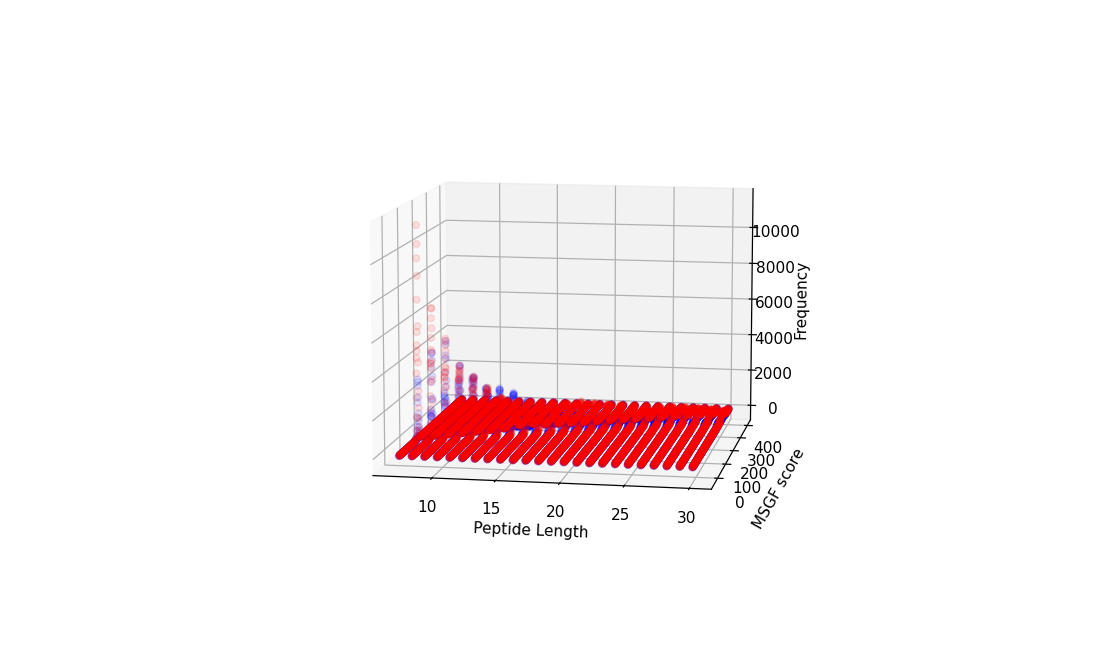

In [93]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d.PeptideLength.values
y = df_nonid_3d.MSGFScore.values
z = df_nonid_3d.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d.PeptideLength.values
y2 = df_id_3d.MSGFScore.values
z2 = df_id_3d.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

In [90]:
df_id_3d_cut = df_id_3d.loc[df_id_3d.Frequency<=4000]
df_nonid_3d_cut = df_nonid_3d.loc[df_nonid_3d.Frequency<=4000]

<IPython.core.display.Javascript object>


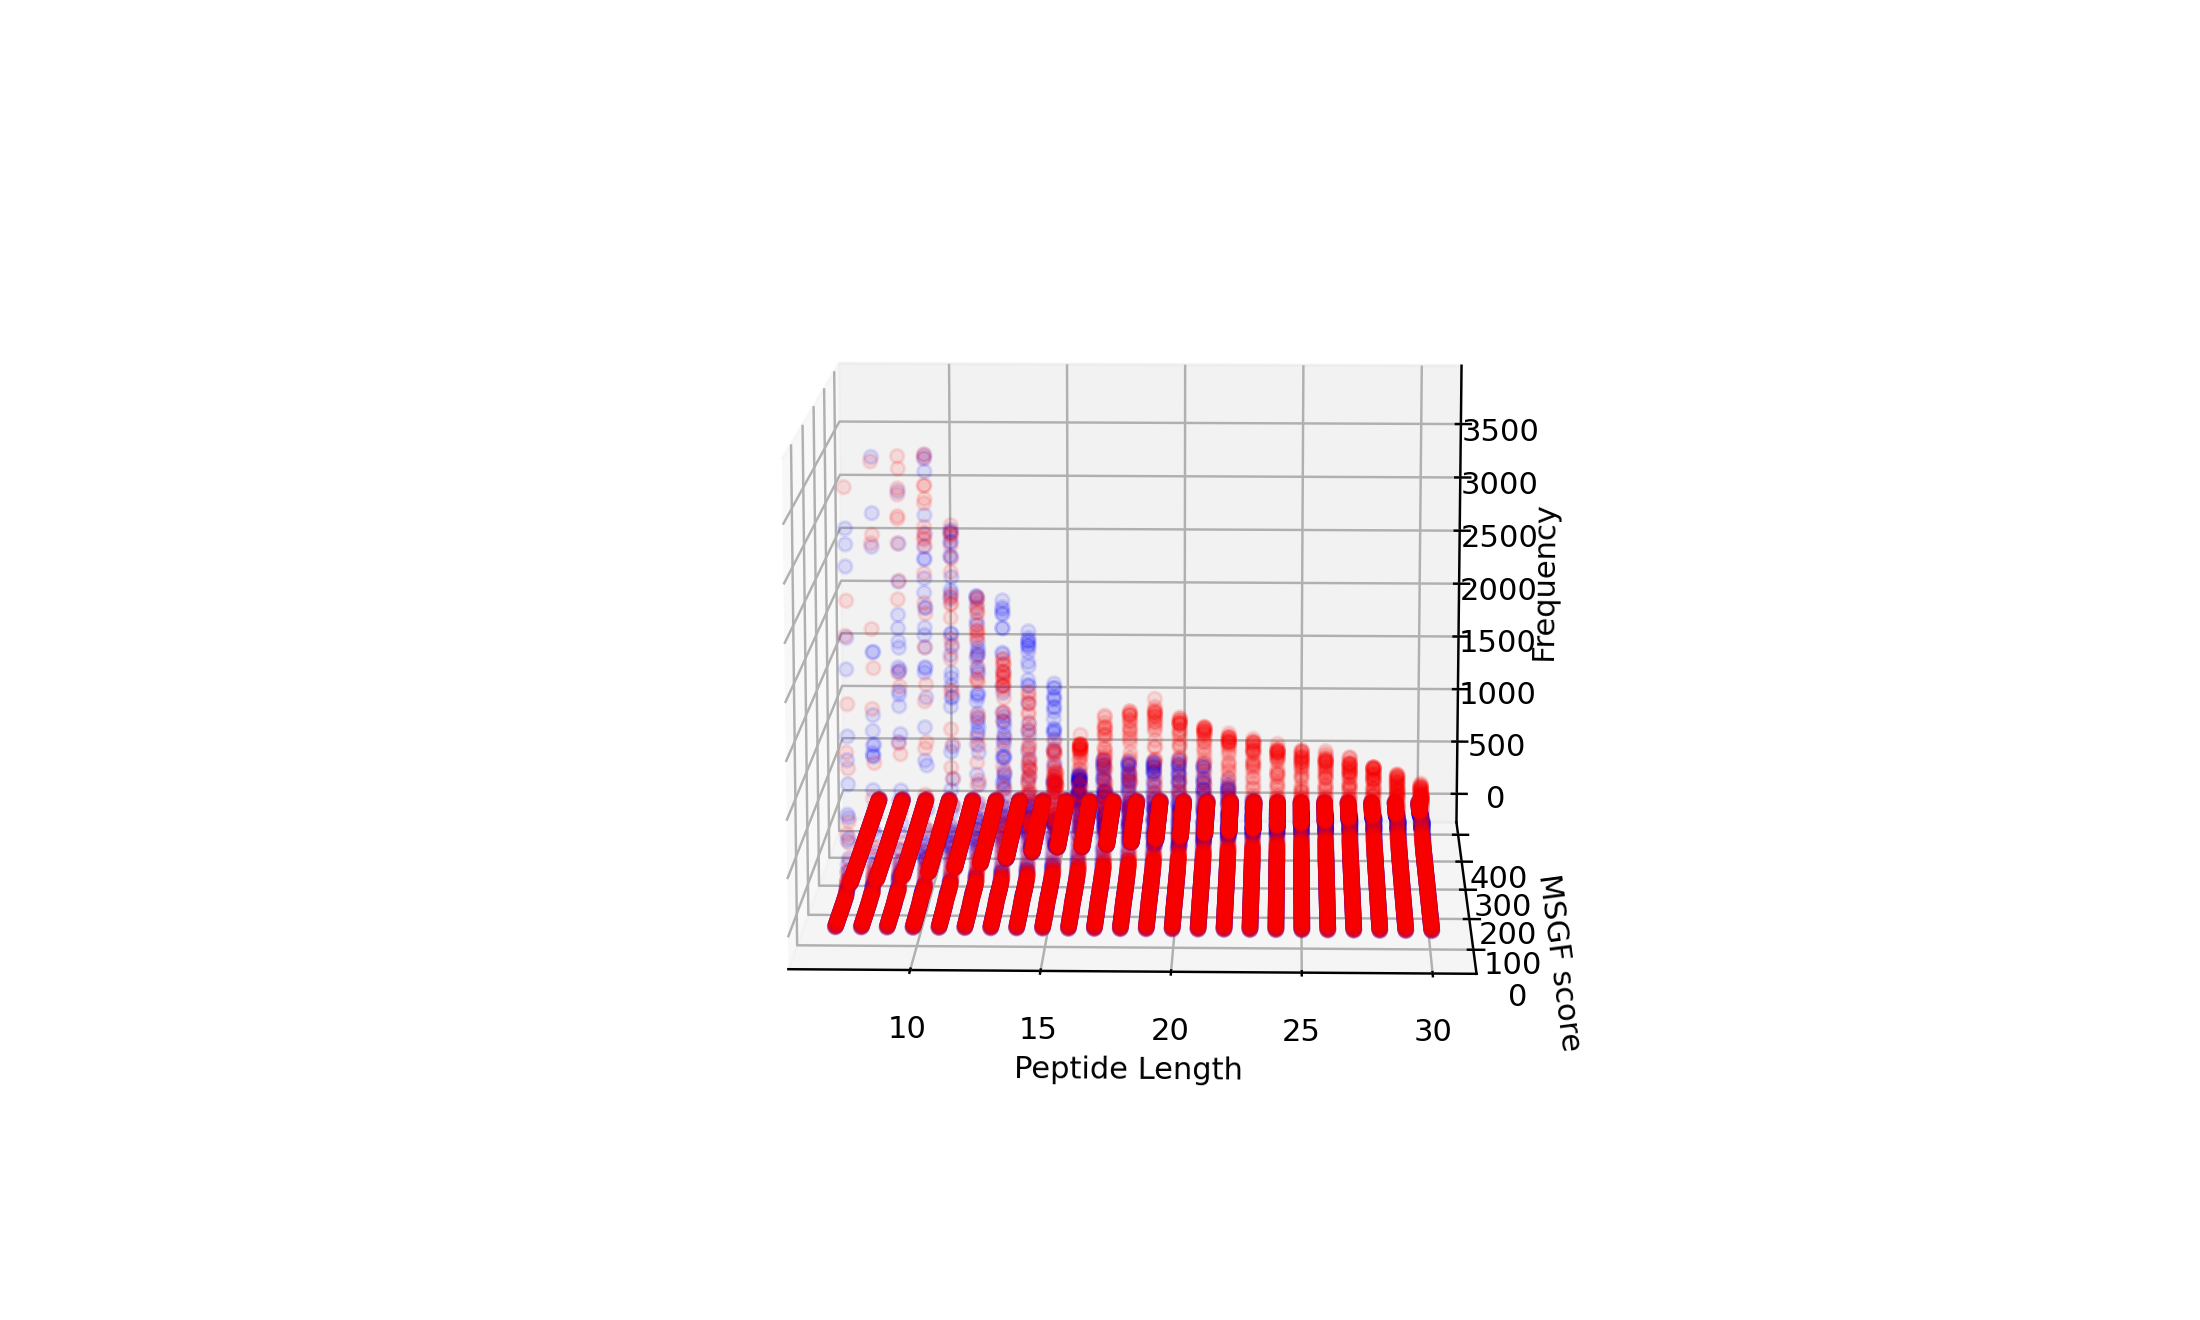

In [105]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_cut.PeptideLength.values
y = df_nonid_3d_cut.MSGFScore.values
z = df_nonid_3d_cut.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_cut.PeptideLength.values
y2 = df_id_3d_cut.MSGFScore.values
z2 = df_id_3d_cut.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

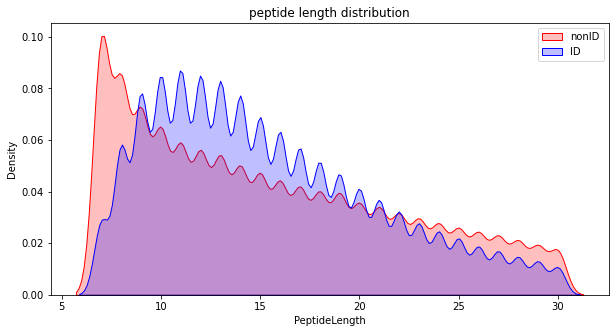

In [125]:
plt.figure(figsize=(10,5))
sns.kdeplot(df_nonid_2d.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d.PeptideLength, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()